In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Input, Reshape, Conv3DTranspose, UpSampling3D, LSTM
from tensorflow.keras.optimizers import Adamax
from skimage.util import random_noise
from skimage.metrics import structural_similarity, mean_squared_error
from scipy.ndimage import rotate
from skimage.transform import resize
import nibabel as nib
from ipywidgets import interact, IntSlider, RadioButtons
import time
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def label_img(img):
  return [0]

def rotateit(image, theta, isseg=False):
  order = 0 if isseg == True else 5
  return ndimage.rotate(image, float(theta), reshape=False, order=order, mode='nearest')

def data_nii_to_npy_2():
  dataset_array = []
  dataset_labels = []
  img_name_array = []
  count = 0

  img_path = "/content/drive/My Drive/FYP_1/"

  img_names = os.listdir(img_path)
  shuffle(img_names)
  for img_name in img_names:
      #print(img_name)
      img_name_array.append(img_name)
      img_new = nib.load(img_path + img_name)#load
      imag_data_nparray = img_new.get_fdata()
      label_current_image=label_img(img_name)
      imag_data_nparray=resize(imag_data_nparray,(32,32,32,1))
      imag_data_nparray = imag_data_nparray.astype('float32') / 255.0
      count +=1
      print(count)
      dataset_array.append(imag_data_nparray)
      dataset_labels.append(label_current_image)

  dataset_array = np.array(dataset_array)
  dataset_labels = np.array(dataset_labels)
  img_name_array = np.array(img_name_array)
  return dataset_array, dataset_labels, img_name_array

In [ ]:
data , labels, names = data_nii_to_npy_2()

In [ ]:
np.save("data.npy", data)
np.save("labels.npy", labels)
res = {names[i]: data[i] for i in range(len(names))}

In [ ]:
train_dataset_array = np.load("data.npy")
train_dataset_array_labels = np.load("labels.npy",allow_pickle=True)

print(train_dataset_array.shape)
print(train_dataset_array_labels.shape)

(227, 32, 32, 32, 1)
(227, 1)


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(train_dataset_array, train_dataset_array_labels, test_size=0.2, stratify=train_dataset_array_labels)

In [ ]:
X_train_noisy = skimage.util.random_noise(trainX, mode='gaussian', seed=None, clip=True)
X_test_noisy = skimage.util.random_noise(testX, mode='gaussian', seed=None, clip=True)

In [ ]:
#noise_factor = 0.5
#X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
#X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

#X_train_noisy = np.clip(X_train_noisy, 0., 1.)
#X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [ ]:
#size is reduced to less due to GPU limit
X_train = trainX.reshape(trainX.shape[0],32,32,32,1)
X_test = testX.reshape(testX.shape[0],32,32,32,1)

In [ ]:
#VGG

#Image Dimension
IMAGE_DIM=(32,32,32,1)

#Required Feature vector size after encoding
ENCODED_SIZE=512

def DeionizingAutoEncoderLSTM(img_dim, encoded_size):
    #Encoder Part
    enc = keras.models.Sequential()
    enc.add(InputLayer(img_dim))
    enc.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling3D(pool_size=(2, 2, 2)))
    enc.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling3D(pool_size=(2, 2, 2)))
    enc.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling3D(pool_size=(2, 2, 2)))
    enc.add(Flatten())
    enc.add(Reshape((16384,1)))
    enc.add(LSTM(units=512, return_sequences=False))
    #enc.add(Dense(4096))
    #enc.add(Reshape((4096,1)))
    #enc.add(LSTM(units=256))
    #enc.add(Dense(1024))
    #enc.add(Reshape((1024,1)))
    #enc.add(LSTM(units=256))
    enc.add(Dense(encoded_size))

    #Decoder Part
    dec = keras.models.Sequential()
    dec.add(InputLayer((encoded_size)))
    dec.add(Reshape((encoded_size,1)))
    #dec.add(LSTM(units=256))
    #dec.add(Dense(1024))
    #dec.add(Reshape((1024,1)))
    #dec.add(LSTM(units=256))
    #dec.add(Dense(4096))
    #dec.add(Reshape((4096,1)))
    dec.add(LSTM(units=512, return_sequences=False))
    dec.add(Dense(16384))
    dec.add(Reshape((4, 4, 4, 256)))
    dec.add(UpSampling3D(size=(2,2,2)))
    dec.add(Conv3DTranspose(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    dec.add(Conv3DTranspose(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    dec.add(UpSampling3D(size=(2,2,2)))
    dec.add(Conv3DTranspose(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    dec.add(Conv3DTranspose(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    dec.add(UpSampling3D(size=(2,2,2)))
    dec.add(Conv3DTranspose(filters=64, kernel_size=(3, 3, 3), activation=None, padding='same'))
    dec.add(Conv3DTranspose(filters=64, kernel_size=(3, 3, 3), activation=None, padding='same'))
    return enc, dec

vggencoder, vggdecoder = DeionizingAutoEncoderLSTM(img_dim=IMAGE_DIM, encoded_size=ENCODED_SIZE)

In [ ]:
vggencoder.summary()
#plot_model(vggencoder, show_shapes=True, show_layer_names=True)

vggdecoder.summary()
#plot_model(vggdecoder, show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 32, 32, 32, 64)    1792      
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 32, 32, 32, 64)    110656    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 16, 16, 16, 64)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 16, 16, 16, 128)   221312    
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 16, 16, 128)   442496    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 8, 8, 128)      0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 8, 8, 256)     

In [ ]:
input = Input(IMAGE_DIM)
encoded = vggencoder(input)
decoded = vggdecoder(encoded)

dae = keras.models.Model(inputs=input, outputs=decoded)
dae.compile(optimizer=Adamax(lr=0.001), loss='mean_squared_error')

In [ ]:
#size is reduced to less due to GPU limit
X_train = trainX.reshape(trainX.shape[0],32,32,32,1)
X_test = testX.reshape(testX.shape[0],32,32,32,1)

In [ ]:
#model_checkpoint=tf.keras.callbacks.ModelCheckpoint('GaussianDAE{epoch:02d}.h5',period=1,save_weights_only=False)

In [ ]:
history = dae.fit(X_train, X_train, batch_size=8, epochs=50, validation_data=(X_test, X_test)) #, callbacks=[model_checkpoint])

Epoch 1/50
23/23 [==============================] - 85s 2s/step - loss: 8.8299 - val_loss: 6.0376
Epoch 2/50
23/23 [==============================] - 45s 2s/step - loss: 4.3559 - val_loss: 2.9079
Epoch 3/50
23/23 [==============================] - 45s 2s/step - loss: 2.4182 - val_loss: 2.3030
Epoch 4/50
23/23 [==============================] - 45s 2s/step - loss: 2.0353 - val_loss: 2.0350
Epoch 5/50
23/23 [==============================] - 45s 2s/step - loss: 1.6615 - val_loss: 1.9395
Epoch 6/50
23/23 [==============================] - 45s 2s/step - loss: 1.4557 - val_loss: 2.8973
Epoch 7/50
23/23 [==============================] - 45s 2s/step - loss: 1.7947 - val_loss: 1.4265
Epoch 8/50
23/23 [==============================] - 45s 2s/step - loss: 1.1309 - val_loss: 1.2112
Epoch 9/50
23/23 [==============================] - 45s 2s/step - loss: 1.0373 - val_loss: 1.4333
Epoch 10/50
23/23 [==============================] - 45s 2s/step - loss: 1.0763 - val_loss: 1.2149
Epoch 11/50
23/23 [

Training Loss:  0.706716001033783
Validation Loss:  0.9178535342216492


Text(0.5, 1.0, 'Training and validation loss')

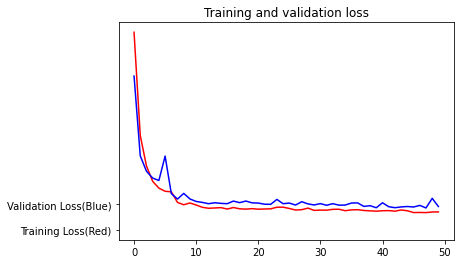

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
print("Training Loss: ",loss[-1])
print("Validation Loss: ",val_loss[-1])
epochs=range(len(loss)) # Get number of epochs
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss(Red)")
plt.plot(epochs, val_loss, 'b', "Validation Loss(Blue)")


plt.title('Training and validation loss')

In [ ]:
print("Training Loss: ", "5.7998825298000156e-08")
print("Validation Loss:  5.817951276299027-08")
print("Training Time: 1289.78945614513661 seconds")

Training Loss:  5.7998825298000156e-08
Validation Loss:  5.817951276299027-08
Training Time: 1289.78945614513661 seconds


In [ ]:
#Save model for later use
dae.save('deionizingAutoEncoder.h5')

# Load the trained Model
from keras.models import load_model
model = load_model('deionizingAutoEncoder.h5')

In [ ]:
# Extract 'Encoder' Part from it
encoder = dae.layers[1]

images = X_train
codes = encoder.predict(images)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def get_similar(image, n_neighbors=5):

    code = encoder.predict(image[None])

    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)

    return distances,images[idx]

def show_similar(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    ImageSliceViewer3D(image.reshape(32,32,32,))

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    for i in range(4):
        ImageSliceViewer3D(neighbors[i+1].reshape(32,32,32))
        print("Dist={:.3f}".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)

class ImageSliceViewer3D:
    def __init__(self, volume, figsize=(3,3), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]

        # Call to select slice plane
        interact(self.view_selection, view=RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))

    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1

        # Call to view a slice within the selected slice plane
        interact(self.plot_slice,
            z=IntSlider(min=0, max=maxZ, step=1, continuous_update=False,
            description='Image Slice:'))

    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap),
            vmin=self.v[0], vmax=self.v[1])

In [ ]:
show_similar(X_test[21])

                                     QUERY IMAGE


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

                                    RETRIEVED IMAGES


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=0.043


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=0.084


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=0.157


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=0.290
Execution Time (in seconds): 1.460404634475708


In [ ]:
def GetKey(val):
   for key, value in res.items():
      if (val == value).all():
        return key

In [ ]:
def show_similar2d(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    plt.imshow(image[:,:,5].reshape(32,32),cmap='gray')
    plt.title("Slice 5")
    plt.show()

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    plt.figure(figsize=(20, 20))
    for i in range(4):
        retrievedname = GetKey(neighbors[i+1])
        print(retrievedname)
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(neighbors[i+1][:,:,5].reshape(32,32),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Dist={:.3f} (Slice 5)".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)


                                     QUERY IMAGE


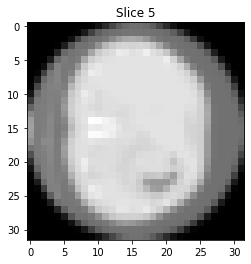

                                    RETRIEVED IMAGES
study_0979.nii
study_1011.nii
study_0998.nii
study_0945.nii


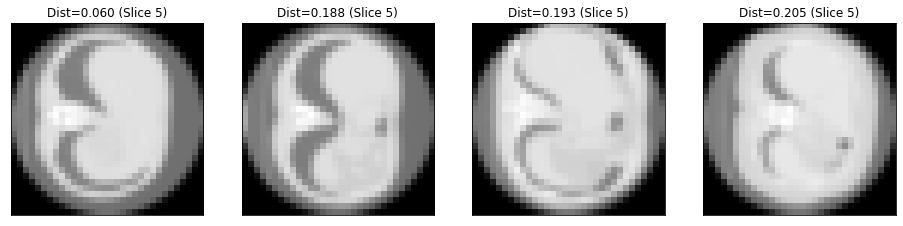

Execution Time (in seconds): 0.9863357543945312


In [ ]:
show_similar2d(X_test[38])

In [ ]:
#a=nib.load('mricn.nii').get_fdata()
#a=resize(a,(32,32,16))
#a=a.reshape(32,32,16,1)
#a=a.astype('float32') / 255.0

In [ ]:
#show_similar(a)